# Convolutional Autoencoder

This time we will use convolutional layers in our autoencoder in order to improve our results.

Of course, we'll stick to MNIST.

## Preliminaries

Let's import the props we'll need.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Getting the Data

Let's fetch again the MNIST dataset using TensorFlow's helper functions.

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## The Architecture

Unlike our previous attempt, this time we will use convolutional layers, both in the encoder as well as in the decoder.

This will also produce a _bottleneck_ feature that's more akin to a matrix or a tensor, than a vector.

The encoder will be a traditional CNN, shaped as a reverse pyramid, where the input gets smaller and deeper as we advance through the network.

The tricky part here is the decoder. In a regular CNN we tend to downsample at each step. Given that the decoder must undo the transformations made by the encoder, it must upsample, i.e., create bigger volumes from smaller and deeper ones, until we arrive at a tensor with the same dimensios as the input image, corresponding to the reconstructed photo.

For more details about upsampling, take a moment to read [this article](https://distill.pub/2016/deconv-checkerboard/).

<img src="images/convolutional_autoencoder.png">

In [3]:
inputs = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

# Encoder
convolution_1 = tf.layers.conv2d(inputs, 16, (3, 3), padding='same', activation=tf.nn.relu)
max_pooling_1 = tf.layers.max_pooling2d(convolution_1, (2, 2), (2, 2), padding='same')
convolution_2 = tf.layers.conv2d(max_pooling_1, 8, (3, 3), padding='same', activation=tf.nn.relu)
max_pooling_2 = tf.layers.max_pooling2d(convolution_2, (2, 2), (2, 2), padding='same')
convolution_3 = tf.layers.conv2d(max_pooling_2, 8, (3, 3), padding='same', activation=tf.nn.relu)
encoded = tf.layers.max_pooling2d(convolution_3, (2, 2), (2, 2), padding='same')

# Decoder
upsample_1 = tf.image.resize_nearest_neighbor(encoded, (7, 7))
convolution_4 = tf.layers.conv2d(upsample_1, 8, (3, 3), padding='same', activation=tf.nn.relu)
upsample_2 = tf.image.resize_nearest_neighbor(convolution_4, (14, 14))
convolution_5 = tf.layers.conv2d(upsample_2, 8, (3, 3), padding='same', activation=tf.nn.relu)
upsample_3 = tf.image.resize_nearest_neighbor(convolution_5, (28, 28))
convolution_6 = tf.layers.conv2d(upsample_3, 16, (3, 3), padding='same', activation=tf.nn.relu)

# Used to convert to convert to regenerated image shape
logits = tf.layers.conv2d(convolution_6, 1, (3, 3), padding='same', activation=None)

decoded = tf.nn.sigmoid(logits, name='decoded')

loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets, logits=logits)
cost = tf.reduce_mean(loss)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

## Training

The training process is fairly similar than before, only that this time we don't need to flatten the images, because we are using convolutional layers, which can process them in their original form.

In [4]:
session = tf.Session()

EPOCHS = 30
BATCH_SIZE = 64

session.run(tf.global_variables_initializer())

for epoch in range(EPOCHS):
    epoch_losses = []
    for _ in range(mnist.train.num_examples // BATCH_SIZE):
        batch = mnist.train.next_batch(BATCH_SIZE)
        images = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = session.run([cost, optimizer], feed_dict={inputs: images, targets: images})
        
        epoch_losses.append(batch_cost)
        
    print(f'Epoch: {epoch + 1}/{EPOCHS}')
    print(f'Training loss: {np.mean(epoch_losses)}')
    

Epoch: 1/30
Training loss: 0.1651708036661148
Epoch: 2/30
Training loss: 0.11713025718927383
Epoch: 3/30
Training loss: 0.1074552834033966
Epoch: 4/30
Training loss: 0.10288354009389877
Epoch: 5/30
Training loss: 0.10015544295310974
Epoch: 6/30
Training loss: 0.09825774282217026
Epoch: 7/30
Training loss: 0.09689218550920486
Epoch: 8/30
Training loss: 0.09580045938491821
Epoch: 9/30
Training loss: 0.09481629729270935
Epoch: 10/30
Training loss: 0.09405802190303802
Epoch: 11/30
Training loss: 0.09343886375427246
Epoch: 12/30
Training loss: 0.09276024997234344
Epoch: 13/30
Training loss: 0.09222368150949478
Epoch: 14/30
Training loss: 0.09181750565767288
Epoch: 15/30
Training loss: 0.09122845530509949
Epoch: 16/30
Training loss: 0.09085310995578766
Epoch: 17/30
Training loss: 0.09048423916101456
Epoch: 18/30
Training loss: 0.09023837000131607
Epoch: 19/30
Training loss: 0.08994704484939575
Epoch: 20/30
Training loss: 0.08966629207134247
Epoch: 21/30
Training loss: 0.08950209617614746
Epo

## Looking at the Results

Again, let's plot the original and the generated images in order to see how well our autoencoder performs.

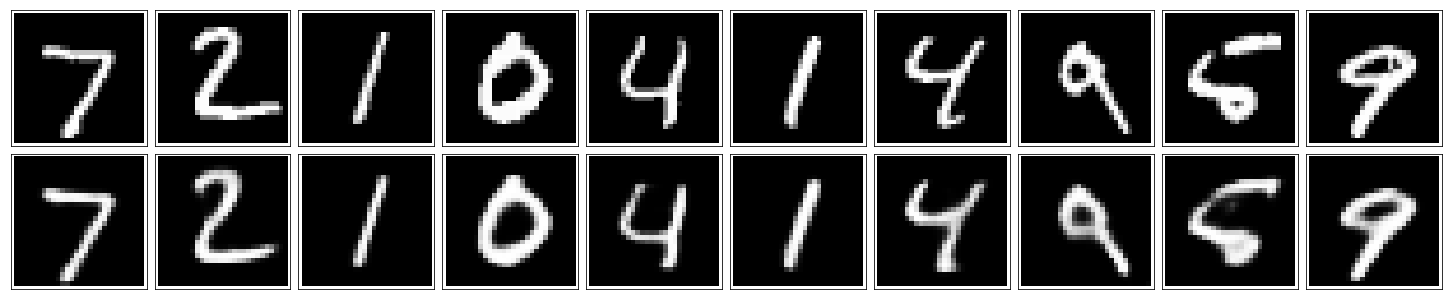

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20, 4))
in_images = mnist.test.images[:10]
reconstructed = session.run(decoded, feed_dict={inputs: in_images.reshape((10, 28, 28, 1))})

for images, row in zip([in_images, reconstructed], axes):
    for image, ax in zip(images, row):
        ax.imshow(image.reshape((28, 28)), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
fig.tight_layout(pad=0.1)

In [6]:
session.close()

## Denoising

Before finishing this notebook, let's apply a new autoencoder to the task of denoising images. In fact, this is the most common usage of these networks.

We'll add some random jitter to the MNIST images to account for the noise the network will try to remove or, at least, reduce.

<img src="images/denoising.png">

This is a harder problem. Hence, our network must have deeper layers.

In [7]:
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

# Encoder
convolution_1 = tf.layers.conv2d(inputs, 32, (3, 3), padding='same', activation=tf.nn.relu)
max_pooling_1 = tf.layers.max_pooling2d(convolution_1, (2, 2), (2, 2), padding='same')
convolution_2 = tf.layers.conv2d(max_pooling_1, 32, (3, 3), padding='same', activation=tf.nn.relu)
max_pooling_2 = tf.layers.max_pooling2d(convolution_2, (2, 2), (2, 2), padding='same')
convolution_3 = tf.layers.conv2d(max_pooling_2, 16, (3, 3), padding='same', activation=tf.nn.relu)
encoded = tf.layers.max_pooling2d(convolution_3, (2, 2), (2, 2), padding='same')

# Decoder
upsample_1 = tf.image.resize_nearest_neighbor(encoded, (7, 7))
convolution_4 = tf.layers.conv2d(upsample_1, 16, (3, 3), padding='same', activation=tf.nn.relu)
upsample_2 = tf.image.resize_nearest_neighbor(convolution_4, (14, 14))
convolution_5 = tf.layers.conv2d(upsample_2, 32, (3, 3), padding='same', activation=tf.nn.relu)
upsample_3 = tf.image.resize_nearest_neighbor(convolution_5, (28, 28))
convolution_6 = tf.layers.conv2d(upsample_3, 32, (3, 3), padding='same', activation=tf.nn.relu)

logits = tf.layers.conv2d(convolution_6, 1, (3, 3), padding='same', activation=None)

decoded = tf.nn.sigmoid(logits, name='decoded')

loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets, logits=logits)
cost = tf.reduce_mean(loss)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

## Training

Here we will add some random noise to the input images to simulate actual noise. Given this is a harder task, we'll train for more epochs.

In [8]:
session = tf.Session()

EPOCHS = 100
BATCH_SIZE = 64

NOISE_FACTOR = 0.5
session.run(tf.global_variables_initializer())

for epoch in range(EPOCHS):
    epoch_losses = []
    for _ in range(mnist.train.num_examples // BATCH_SIZE):
        batch = mnist.train.next_batch(BATCH_SIZE)
        images = batch[0].reshape((-1, 28, 28, 1))
        
        # Add noise
        noisy_images = images + NOISE_FACTOR * np.random.randn(*images.shape)
        
        # Clip the images to be between 0 and 1
        noisy_images = np.clip(noisy_images, 0.0, 1.0)
        
        # Noisy images are the input and the original ones are the target
        batch_cost, _ = session.run([cost, optimizer], feed_dict={inputs: noisy_images, targets: images})
        epoch_losses.append(batch_cost)
        
    print(f'Epoch: {epoch + 1}/{EPOCHS}')
    print(f'Training loss: {np.mean(epoch_losses)}')

Epoch: 1/100
Training loss: 0.17649102210998535
Epoch: 2/100
Training loss: 0.1310097724199295
Epoch: 3/100
Training loss: 0.12205958366394043
Epoch: 4/100
Training loss: 0.11715901643037796
Epoch: 5/100
Training loss: 0.1139821782708168
Epoch: 6/100
Training loss: 0.11180433630943298
Epoch: 7/100
Training loss: 0.11019301414489746
Epoch: 8/100
Training loss: 0.10901259630918503
Epoch: 9/100
Training loss: 0.10776770114898682
Epoch: 10/100
Training loss: 0.10694386810064316
Epoch: 11/100
Training loss: 0.10620078444480896
Epoch: 12/100
Training loss: 0.10553362965583801
Epoch: 13/100
Training loss: 0.10496725887060165
Epoch: 14/100
Training loss: 0.10454615950584412
Epoch: 15/100
Training loss: 0.10399317741394043
Epoch: 16/100
Training loss: 0.10370020568370819
Epoch: 17/100
Training loss: 0.10342174023389816
Epoch: 18/100
Training loss: 0.10309462994337082
Epoch: 19/100
Training loss: 0.10283569246530533
Epoch: 20/100
Training loss: 0.10265280306339264
Epoch: 21/100
Training loss: 0.

## Performance Test

Did it work? Let's see.

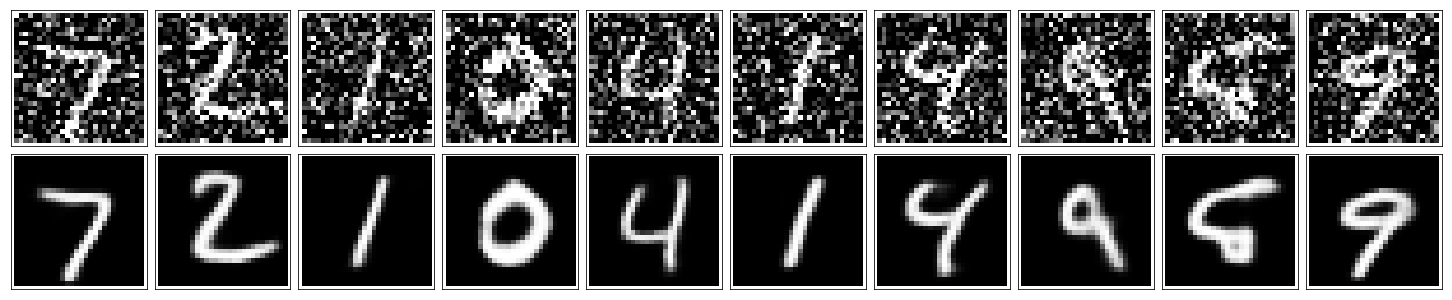

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20, 4))
in_images = mnist.test.images[:10]
noisy_images = in_images + NOISE_FACTOR * np.random.randn(*in_images.shape)
noisy_images = np.clip(noisy_images, 0.0, 1.0)

reconstructed = session.run(decoded, feed_dict={inputs: noisy_images.reshape((-1, 28, 28, 1))})

for images, row in zip([noisy_images, reconstructed], axes):
    for image, ax in zip(images, row):
        ax.imshow(image.reshape((28, 28)), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
fig.tight_layout(pad=0.1)

Pretty cool, huh?